In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from IPython.display import Audio

In [ ]:
def load_metadata(metadata_file):
    """Load metadata from the Excel file."""
    return pd.read_excel(metadata_file)

In [ ]:
def load_dataset(directory, metadata):
    """Load dataset paths and enrich with metadata."""
    paths, labels = [], []

    # Ensure metadata `New_ID` column is a string and has no extra spaces
    metadata['New_ID'] = metadata['New_ID'].astype(str).str.strip()

    # Iterate through all the files in the dataset directory
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.wav'):# Only process .wav files
                full_path = os.path.join(dirname, filename)

                # Extract file_id from filename (assuming format: 'S_01_4002_VE1.wav')
                try:
                    file_id = filename.split('_')[2]  # Extract ID
                    file_id = file_id.strip()  # Remove extra spaces
                except IndexError:
                    print(f"Filename format issue: {filename}")
                    continue  # Skip invalid filenames

                # Check if extracted file_id exists in metadata
                if file_id not in metadata['New_ID'].values:
                    print(f"No match found for ID: {file_id} (from {filename})")
                    continue  # Skip if no match found

                # Retrieve gender
                gender_series = metadata.loc[metadata['New_ID'] == file_id, 'Sex']
                gender = gender_series.values[0].strip("'").lower()  # Ensure clean data

                # Assign label
                label = 'male' if gender == 'male' else 'female'
                paths.append(full_path)
                labels.append(label)

    # Return paths and labels in a DataFrame
    return pd.DataFrame(list(zip(paths, labels)), columns=['path', 'label'])

In [ ]:
# Plot the distribution of labels (male/female)
def plot_label_distribution(dataset):
    sns.countplot(x='label', data=dataset)
    plt.show()

In [ ]:
# Display the waveform of an audio sample
def displayaudio(data,sr):
    plt.figure(figsize=(9,4))
    plt.title('Audio Signal')
    librosa.display.waveshow(data,sr=sr)
    plt.show()

In [ ]:
# Extract MFCC (Mel-frequency cepstral coefficients) feature from an audio file
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

In [ ]:
# Preprocess dataset by extracting features and encoding labels
def preprocess_dataset(dataset):
    dataset['mfcc'] = dataset['path'].apply(extract_feature)
    labelencoder = LabelEncoder()
    dataset['label'] = labelencoder.fit_transform(dataset['label'])
    return dataset, to_categorical(dataset['label'], num_classes=2)

In [ ]:
# Prepare features and labels for model training
def prepare_features_labels(dataset, labels):
    features = np.array([feature for feature in dataset['mfcc']])
    features = np.expand_dims(features, axis=-1)
    return train_test_split(features, labels, test_size=0.3, random_state=42)

In [ ]:
# Build the LSTM-based model
def build_model():
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(40, 1)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')  # Output layer (2 classes: male/female)
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['accuracy'])
    return model

In [ ]:
# Train the model on training data
def train_model(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=70, batch_size=512, shuffle=True)
    return history

In [ ]:
# Evaluate the model on test data and print accuracy
def evaluate_model(model, x_test, y_test):
    predictions = model.predict(x_test).round()
    accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))
    print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Save the trained model to a file
def save_model(model, model_path):
    """Save the trained model to the specified path."""
    model.save(model_path)
    print(f"Model saved to {model_path}")

In [ ]:
# Load a previously saved model
def load_saved_model(model_path):
    """Load a previously saved model."""
    model = load_model(model_path)
    print(f"Model loaded from {model_path}")
    return model

In [ ]:
# Predict gender for a given audio file
def predict_audio(model, file_path):
    """Make a prediction on a single audio file."""
    feature = extract_feature(file_path).reshape(1, 40, 1)
    prediction = model.predict(feature).argmax(axis=1)[0]
    label = 'male' if prediction == 0 else 'female'
    print(f"Predicted label: {label}")
    return label

In [ ]:
# Data Path
metadata_file = '/Gender Age Classification from voice data/BVC_Voice_Bio_Public.xlsx'
data_directory = '/Gender Age Classification from voice data/Voice Data'
model_path = 'audio_model.h5'

In [ ]:
# Load metadata from file
metadata = load_metadata(metadata_file)

In [ ]:
#Compute statistics
df = metadata

# Clean up and process the 'Sex' and 'Ethnicity' columns
df['Sex'] = df['Sex'].str.replace("'", "").str.strip().str.lower()
df['Ethnicity'] = df['Ethnicity'].str.replace("'", "").str.strip()

# Compute and print statistics on gender and ethnicity distribution
print("Valeurs uniques de 'Sex':", df['Sex'].unique())
print("Valeurs uniques de 'Ethnicity':", df['Ethnicity'].unique()[:10])

total_subjects = df['New_ID'].nunique()
male_count = df[df['Sex'] == 'male']['New_ID'].nunique()
female_count = df[df['Sex'] == 'female']['New_ID'].nunique()

print(f"Nombre total de sujets : {total_subjects}")
print(f"Nombre de sujets masculins : {male_count}")
print(f"Nombre de sujets féminins : {female_count}")

Valeurs uniques de 'Sex': ['male' 'female']
Valeurs uniques de 'Ethnicity': ['Igbo' 'Ikwerre' 'Annang' 'Ishan' 'Ijaw' 'Hausa' 'Urhobo' 'Ibibio'
 'Ukwuani' 'Idoma']
Nombre total de sujets : 560
Nombre de sujets masculins : 363
Nombre de sujets féminins : 197


In [ ]:
# Load dataset
dataset = load_dataset(data_directory, metadata)

In [ ]:
print(dataset.head()) # Display a sample of the dataset

                                                path   label
0  /content/drive/MyDrive/NLP-Project-Fatima/Gend...    male
1  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
2  /content/drive/MyDrive/NLP-Project-Fatima/Gend...    male
3  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
4  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female


In [ ]:
print(dataset['path'].value_counts()) # Display the label distribution

path
/content/drive/MyDrive/NLP-Project-Fatima/Gender Age Classification from voice data/Voice Data/one_sentence/S_01_4001_VE.wav           1
/content/drive/MyDrive/NLP-Project-Fatima/Gender Age Classification from voice data/Voice Data/S_02/S_02_4471_VV4.wav                  1
/content/drive/MyDrive/NLP-Project-Fatima/Gender Age Classification from voice data/Voice Data/S_02/S_02_4498_VE1.wav                  1
/content/drive/MyDrive/NLP-Project-Fatima/Gender Age Classification from voice data/Voice Data/S_02/S_02_4498_VE4.wav                  1
/content/drive/MyDrive/NLP-Project-Fatima/Gender Age Classification from voice data/Voice Data/S_02/S_02_4484_VV4.wav                  1
                                                                                                                                      ..
/content/drive/MyDrive/NLP-Project-Fatima/Gender Age Classification from voice data/Voice Data/multiple_sentences/S_01_4776_VE3.wav    1
/content/drive/MyDrive/NLP-Project-F

In [ ]:
print(len(dataset['path']))

3964


In [ ]:
print(dataset['label'].unique())

['male' 'female']


In [ ]:
print(dataset['path'][1])

/content/drive/MyDrive/NLP-Project-Fatima/Gender Age Classification from voice data/Voice Data/one_sentence/S_01_4003_VE.wav


In [ ]:
print(dataset['label'] == 'male')

0        True
1       False
2        True
3       False
4       False
        ...  
3959     True
3960    False
3961    False
3962     True
3963    False
Name: label, Length: 3964, dtype: bool


In [ ]:
print(dataset[dataset['label'] == 'male'])

                                                   path label
0     /content/drive/MyDrive/NLP-Project-Fatima/Gend...  male
2     /content/drive/MyDrive/NLP-Project-Fatima/Gend...  male
6     /content/drive/MyDrive/NLP-Project-Fatima/Gend...  male
9     /content/drive/MyDrive/NLP-Project-Fatima/Gend...  male
12    /content/drive/MyDrive/NLP-Project-Fatima/Gend...  male
...                                                 ...   ...
3954  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  male
3956  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  male
3957  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  male
3959  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  male
3962  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  male

[2149 rows x 2 columns]


In [ ]:
print(dataset[dataset['label'] == 'female'])

                                                   path   label
1     /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
3     /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
4     /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
5     /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
7     /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
...                                                 ...     ...
3955  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
3958  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
3960  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
3961  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female
3963  /content/drive/MyDrive/NLP-Project-Fatima/Gend...  female

[1815 rows x 2 columns]


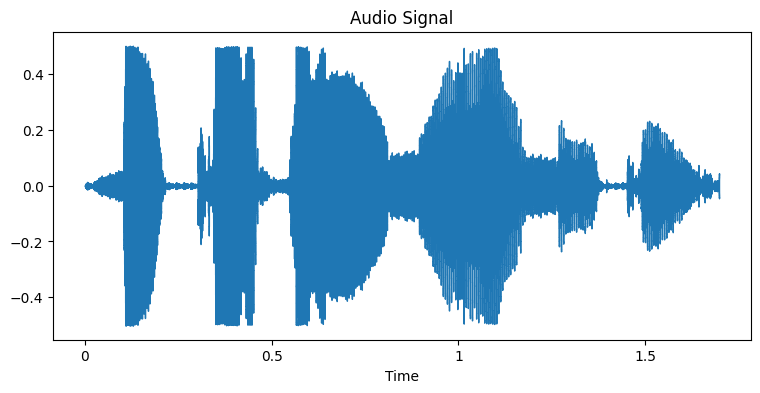

In [ ]:
# Visualize an audio sample
path=dataset['path'].iloc[3960]
data,sr=librosa.load(path)
displayaudio(data,sr)
# show the audio using IPython
Audio(data,rate=sr)

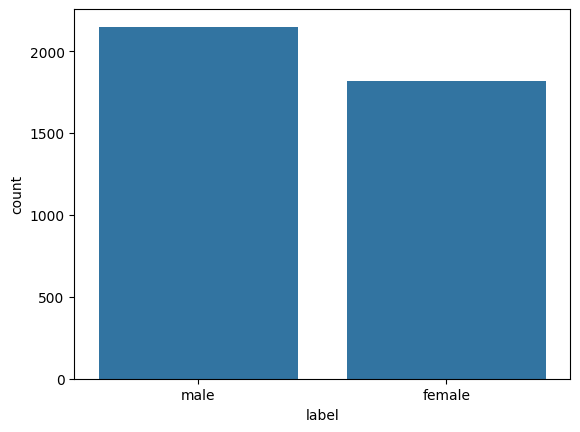

In [ ]:
# Plot label distribution
plot_label_distribution(dataset)

In [ ]:
# Preprocess dataset
dataset, labels = preprocess_dataset(dataset)

In [ ]:
# Prepare features and labels
x_train, x_test, y_train, y_test = prepare_features_labels(dataset, labels)

In [ ]:
# Build the LSTM model
model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,458 (302.57 KB)

 Trainable params: 77,458 (302.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train, and save the model
history = train_model(model, x_train, y_train, x_test, y_test)
save_model(model, model_path)

Epoch 1/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.4523 - loss: 0.6857 - val_accuracy: 0.4664 - val_loss: 0.6435
Epoch 2/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - accuracy: 0.4718 - loss: 0.6651 - val_accuracy: 0.4866 - val_loss: 0.6340
Epoch 3/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.4705 - loss: 0.6635 - val_accuracy: 0.5714 - val_loss: 0.6337
Epoch 4/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.5096 - loss: 0.6537 - val_accuracy: 0.7118 - val_loss: 0.6309
Epoch 5/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.5656 - loss: 0.6499 - val_accuracy: 0.7521 - val_loss: 0.6278
Epoch 6/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.6274 - loss: 0.6444 - val_accuracy: 0.7605 - val_loss: 0.6263
Epoch 7/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step - accuracy: 0.6670 - loss: 0.6425 - val_accuracy: 0.7672 - val_loss: 0.6274
Epoch 8/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 336ms/step - accuracy: 0.6952 - loss: 0.6388 - val_accuracy: 0.7672 - val_loss:

Model saved to /content/drive/MyDrive/NLP-Project-Fatima/saved_model/audio_model.h5


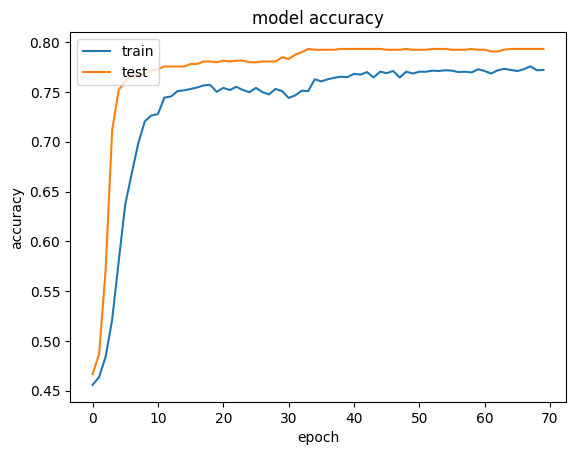

In [ ]:
# accuracy and valudation accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

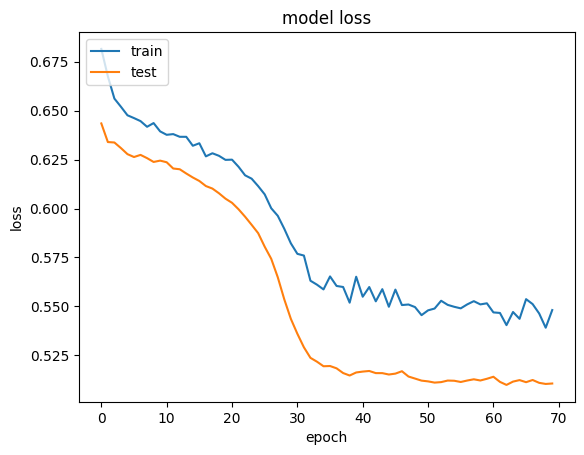

In [ ]:
#loss and valudation loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [ ]:
# Load the model and evaluate it
loaded_model = load_saved_model(model_path)
evaluate_model(loaded_model, x_test, y_test)

Model loaded from /content/drive/MyDrive/NLP-Project-Fatima/saved_model/audio_model.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Accuracy: 79.33%


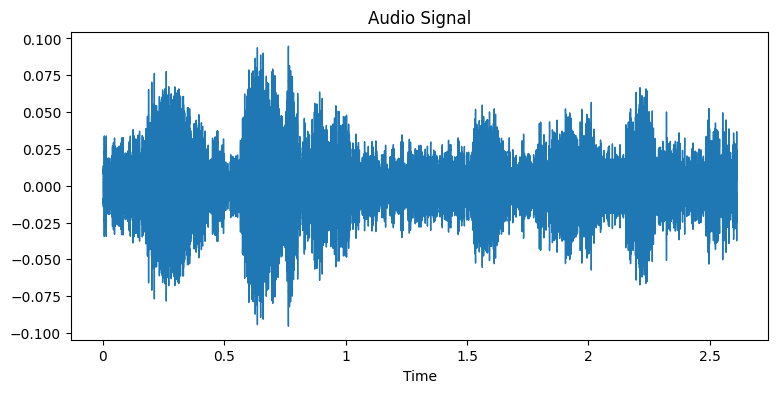

In [ ]:
path=dataset['path'].iloc[171]
data,sr=librosa.load(path)
displayaudio(data,sr)
# show the audio using IPython
Audio(data,rate=sr)

In [ ]:
# Predict a single audio file (example)
example_file = dataset['path'].iloc[171]  # Use file in the dataset
predict_audio(loaded_model, example_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted label: female


'female'